In [1]:
import geopandas as gpd

import numpy as np
import pandas as pd
from pandas import IndexSlice as idx
import tensorflow as tf
import sys
import os
import glob

from functools import partial
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt




code_dir = '/cluster/home/kheuto01/code/opioid-overdose-models/perturbations/'
sys.path.append(code_dir)
code_dir = '/cluster/home/kheuto01/code/opioid-overdose-models/diff_bpr'
sys.path.append(code_dir)
from top_k import top_k_idx
#from make_datasets import make_data
from bpr_model import PerturbedBPRLinearModel, PerturbedBPRMLPModel
from make_datasets import make_data


code_dir = '/cluster/home/kheuto01/code/opioid-overdose-models/'
sys.path.append(code_dir)
from zinf_gp.metrics import normcdf, fixed_top_X



from perturbations import perturbed
from bpr import bpr_variable_k_no_ties



2023-06-27 04:25:57.730616: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-27 04:25:57.942974: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 04:25:58.090386: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 04:25:58.091205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 04:26:03.485659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
data_path='/cluster/tufts/hugheslab/datasets/NSF_OD/results_20220606_update/clean_annual_tract/'

In [3]:
best_model = 'n0.3_samp50_lr0.01_hs50_10_lb5'
noise = 0.3
perturbation_samples = 50
hidden_sizes = [50, 10]
lookback_years=5
learning_rate=0.01
add_spacetime=True
add_svi=True

In [4]:
epochs = 3000
seed = 360
time_window = lookback_years
timesteps_per_year = 1
first_train_eval_year = 2013
last_train_eval_year = 2017
batch_dim_size = (last_train_eval_year - first_train_eval_year + 1)*timesteps_per_year
validation_year = 2018
first_test_year = 2019
last_test_year = 2020


tf.random.set_seed(seed)


timestep_col = 'timestep'
geography_col = 'geoid'
outcome_col = 'deaths'

x_idx_cols = [geography_col, 'lat', 'lon', timestep_col,
              'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
              'svi_pctile', 'year',
              'neighbor_t', 'deaths']
y_idx_cols = [geography_col, timestep_col, outcome_col]
features_only = ['deaths']

if add_spacetime:
    features_only += ['lat', 'lon', timestep_col]
if add_svi:
    features_only += ['theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile']


#data_gdf = gpd.read_file(data_path)

multiindexed_gdf = data_gdf.set_index(['geoid', 'timestep'])
multiindexed_gdf['timestep'] = multiindexed_gdf.index.get_level_values('timestep')
num_geoids = len(data_gdf['geoid'].unique())

train_shape = (num_geoids, time_window, len(features_only))

train_x_BSF_flat, train_y_BS = make_data(multiindexed_gdf, first_train_eval_year, last_train_eval_year,
                                                  time_window, features_only, train_shape, pred_lag=timesteps_per_year)

valid_x_BSF_flat, valid_y_BS = make_data(multiindexed_gdf, validation_year, validation_year,
                                         time_window, features_only, train_shape, pred_lag=timesteps_per_year)

test_x_BSF_flat, test_y_BS = make_data(multiindexed_gdf, first_test_year, last_test_year,
                                       time_window, features_only, train_shape, pred_lag=timesteps_per_year)

norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(train_x_BSF_flat)
train_x_BSF_flat = norm_layer(train_x_BSF_flat)
valid_x_BSF_flat = norm_layer(valid_x_BSF_flat)
test_x_BSF_flat = norm_layer(test_x_BSF_flat)

top_100_idx_func = partial(top_k_idx, k=100)

2023-06-27 04:26:40.013059: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-27 04:26:40.013101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: s1cmp008.pax.tufts.edu
2023-06-27 04:26:40.013110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: s1cmp008.pax.tufts.edu
2023-06-27 04:26:40.013202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 515.65.1
2023-06-27 04:26:40.013235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 515.65.1
2023-06-27 04:26:40.013242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 515.65.1


In [5]:
perturbed_top_100 = perturbed(top_100_idx_func,
                              num_samples=perturbation_samples,
                              sigma=noise,
                              noise='normal',
                              batched=True)

model = PerturbedBPRMLPModel(perturbed_top_k_func=perturbed_top_100,
                                hidden_sizes=[50, 10])

In [7]:
model(train_x_BSF_flat)

<tf.Tensor: shape=(5, 1620), dtype=float32, numpy=
array([[ 0.3502578 , -0.49612334,  0.2736311 , ...,  0.22349277,
        -0.24558276, -0.26356593],
       [ 0.28416812, -0.08019453,  0.4640348 , ..., -0.00237096,
        -0.06913522, -0.11938585],
       [ 0.16539524,  0.22960857,  0.18269122, ...,  0.03205135,
         0.08503486,  0.00608064],
       [ 0.14228319, -0.11706774, -0.19358248, ..., -0.03686664,
         0.05179895, -0.11443582],
       [ 0.03390955, -0.33706975, -0.6064488 , ..., -0.42580017,
        -0.13683595, -0.19226596]], dtype=float32)>

In [8]:
model.load_weights('/cluster/tufts/hugheslab/kheuto01/diffbpr/mlp_annual/n0.3_samp50_lr0.01_hs50_10_lb5/model_2926.hdf5')
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
def weird_loss(a, b):
    return -a / b

model.compile(optimizer=optimizer, loss=weird_loss)


In [10]:
model.evaluate(test_x_BSF_flat, test_y_BS)

1/1 [==============================] - 0s 192ms/step - loss: -0.6343


-0.6342728137969971

In [45]:
# naive model

In [5]:
bprs=[]
avg_2017 = multiindexed_gdf[(multiindexed_gdf['year']<=2017)&(multiindexed_gdf['year']>2010)].groupby(level='geoid')['deaths'].mean()
for quarter in [18]:
    this_2018 = multiindexed_gdf.loc[idx[:,quarter],:].drop(columns='timestep').reset_index().set_index('geoid')['deaths']
    bprs.append(fixed_top_X(this_2018,avg_2017,X=100)[-1])
np.mean(bprs)

0.5852108559498955

In [6]:
bprs=[]
avg_2018 = multiindexed_gdf[(multiindexed_gdf['year']<=2018)&(multiindexed_gdf['year']>2011)].groupby(level='geoid')['deaths'].mean()
for quarter in [19]:
    this_2019 = multiindexed_gdf.loc[idx[:,quarter],:].drop(columns='timestep').reset_index().set_index('geoid')['deaths']
    bprs.append(fixed_top_X(this_2019,avg_2018,X=100)[-1])
np.mean(bprs)

0.6079358974358975

In [7]:
bprs=[]
avg_2019 = multiindexed_gdf[(multiindexed_gdf['year']<=2019)&(multiindexed_gdf['year']>2012)].groupby(level='geoid')['deaths'].mean()
for quarter in [20]:
    this_2020 = multiindexed_gdf.loc[idx[:,quarter],:].drop(columns='timestep').reset_index().set_index('geoid')['deaths']
    bprs.append(fixed_top_X(this_2020,avg_2019,X=100)[-1])
np.mean(bprs)

0.564370741482966

In [8]:
(0.5648296593186374+0.6083461538461538)/2

0.5865879065823956

In [15]:
bprs=[]
avg_2018 = multiindexed_gdf[(multiindexed_gdf['year']<=2018)&(multiindexed_gdf['year']>2017)].groupby(level='geoid')['deaths'].mean()
for quarter in [19]:
    this_2019 = multiindexed_gdf.loc[idx[:,quarter],:].drop(columns='timestep').reset_index().set_index('geoid')['deaths']
    bprs.append(fixed_top_X(this_2019,avg_2018,X=100)[-1])
avg_2019 = multiindexed_gdf[(multiindexed_gdf['year']<=2019)&(multiindexed_gdf['year']>2018)].groupby(level='geoid')['deaths'].mean()
for quarter in [20]:
    this_2020 = multiindexed_gdf.loc[idx[:,quarter],:].drop(columns='timestep').reset_index().set_index('geoid')['deaths']
    bprs.append(fixed_top_X(this_2020,avg_2019,X=100)[-1])
np.mean(bprs)

0.5300052840724183

In [16]:
maes=[]
avg_2018 = multiindexed_gdf[(multiindexed_gdf['year']<=2018)&(multiindexed_gdf['year']>2017)].groupby(level='geoid')['deaths'].mean()
for quarter in [19]:
    this_2019 = multiindexed_gdf.loc[idx[:,quarter],:].drop(columns='timestep').reset_index().set_index('geoid')['deaths']
    maes.append(mean_absolute_error(this_2019,avg_2018))
    
avg_2019 = multiindexed_gdf[(multiindexed_gdf['year']<=2019)&(multiindexed_gdf['year']>2018)].groupby(level='geoid')['deaths'].mean()
for quarter in [20]:
    this_2020 = multiindexed_gdf.loc[idx[:,quarter],:].drop(columns='timestep').reset_index().set_index('geoid')['deaths']
    maes.append(mean_absolute_error(this_2020,avg_2019))
np.mean(maes)

1.0444444444444443

In [17]:
rmses=[]
avg_2018 = multiindexed_gdf[(multiindexed_gdf['year']<=2018)&(multiindexed_gdf['year']>2017)].groupby(level='geoid')['deaths'].mean()
for quarter in [19]:
    this_2019 = multiindexed_gdf.loc[idx[:,quarter],:].drop(columns='timestep').reset_index().set_index('geoid')['deaths']
    rmses.append(sqrt(mean_squared_error(this_2019,avg_2018)))
    
avg_2019 = multiindexed_gdf[(multiindexed_gdf['year']<=2019)&(multiindexed_gdf['year']>2018)].groupby(level='geoid')['deaths'].mean()
for quarter in [20]:
    this_2020 = multiindexed_gdf.loc[idx[:,quarter],:].drop(columns='timestep').reset_index().set_index('geoid')['deaths']
    maes.append(sqrt(mean_squared_error(this_2020,avg_2019)))
np.mean(rmses)

1.4987649236275502

In [14]:
test_preds_mlp = model(test_x_BSF_flat)

In [51]:
test_preds_mlp

<tf.Tensor: shape=(2, 1620), dtype=float32, numpy=
array([[  4.790946 ,  -1.0966846, -22.888494 , ..., -15.398768 ,
        -16.593287 , -16.153664 ],
       [  8.038911 ,   6.3367324, -24.005043 , ..., -18.427742 ,
        -20.498041 , -20.053053 ]], dtype=float32)>

In [17]:
top_mlp_vals, top_mlp_inds =  tf.math.top_k(test_preds_mlp,k=100)
top_naive_vals_2020, top_naive_inds_2020 = tf.math.top_k(avg_2019,k=100)

In [59]:
test_y_BS[0].numpy()[top_mlp_inds[0].numpy()]

array([4., 1., 6., 7., 4., 5., 6., 2., 3., 3., 2., 0., 7., 6., 4., 2., 7.,
       4., 4., 5., 3., 6., 4., 2., 3., 2., 6., 2., 1., 5., 0., 3., 1., 5.,
       3., 3., 2., 1., 3., 3., 4., 5., 2., 2., 1., 2., 6., 5., 0., 2., 1.,
       3., 1., 4., 2., 1., 0., 2., 2., 2., 7., 2., 1., 3., 4., 2., 0., 4.,
       1., 4., 1., 5., 2., 4., 3., 7., 3., 2., 4., 4., 1., 3., 0., 2., 3.,
       2., 1., 6., 2., 3., 2., 0., 6., 3., 2., 6., 4., 2., 2., 2.],
      dtype=float32)

In [19]:
common_2020 = set(top_naive_inds_2020.numpy()).intersection(set(top_mlp_inds[1].numpy()))
mlp_only_2020 = set(top_mlp_inds[1].numpy()).difference(set(top_naive_inds_2020.numpy()))

naive_only_2020 = set(top_naive_inds_2020.numpy()).difference(set(top_mlp_inds[1].numpy()))

In [77]:
top_mlp_inds[1]

<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([1517, 1129,  383,  158, 1514,  268,  115, 1524,  262,  332,  195,
       1391,  349,  347, 1185,  152,  267, 1132,  211,  148, 1295, 1516,
       1334,  120, 1256, 1532,   57,  570, 1017,  140, 1540,  244, 1128,
        156, 1535,  571,  440,  198,  264,  258,  138, 1298,  346, 1384,
       1452,  439,  893, 1518,   62, 1534,  486,  210,  610,  344,  461,
        453, 1465,  374,  266,  472,  270,  167,  261,  161, 1466, 1607,
       1327,  474, 1315,   96, 1597,  354,  189, 1398, 1489,  578, 1119,
       1316, 1523,  569, 1521, 1016,  470,  431,  436,  576,  117, 1515,
         58, 1312,  201,  183,  723, 1599, 1510,  478, 1313,  483, 1050,
       1598], dtype=int32)>

/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/ptopk_tf_again/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_148298/1468682687.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set3',4)


<Axes: >

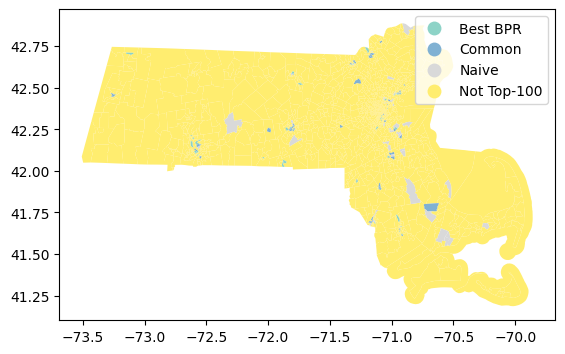

In [60]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

gdf_2020 = multiindexed_gdf[multiindexed_gdf['year']==2020]
gdf_2020['common']='Not Top-100'
gdf_2020.loc[gdf_2020.index[list(common_2020)], 'common'] = 'Common'

gdf_2020.loc[gdf_2020.index[list(mlp_only_2020)], 'common'] = 'Best BPR'
gdf_2020.loc[gdf_2020.index[list(naive_only_2020)], 'common'] = 'Naive'
cmap = cm.get_cmap('Set3',4)
gdf_2020.plot('common', cmap=cmap, legend=True)

In [61]:
shape_dir ='/cluster/tufts/hugheslab/datasets/NSF_OD/results_20220606_update/'
new_tract_shapefile = os.path.join(os.path.dirname(os.path.dirname(shape_dir)),'shapefiles','new_trimmed_tract',
                                   'cb_2020_tract')

mass_gdf = gpd.read_file(new_tract_shapefile)

In [76]:
import copy
import matplotlib
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
new_colors = copy.deepcopy(list(cmap.colors))

# Swap the 3rd and 4th colors in the copied list
new_colors[2], new_colors[3] = new_colors[3], new_colors[2]

# Create a new colormap with the swapped colors
new_cmap = ListedColormap(new_colors, name='Swapped Colormap')

green_co = copy.deepcopy(new_cmap.colors[0])
green_cm = ListedColormap(green_co, name='gco')
blue_co = copy.deepcopy(new_cmap.colors[1])
blue_cm = ListedColormap(blue_co, name='bco')
red_co = copy.deepcopy('#fb8072')
red_cm = ListedColormap(red_co, name='rco')

yellow_co = copy.deepcopy(new_cmap.colors[2])
yellow_cm = ListedColormap(yellow_co, name='yco')
gray_co = copy.deepcopy(new_cmap.colors[3])
gray_cm = ListedColormap(gray_co, name='gco')

final_cmap = ListedColormap([red_co, blue_co, yellow_co, gray_co], name='Final Colormap')


/tmp/ipykernel_148298/3472025783.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf.loc[top_100, 'geometry'] = merged_gdf.geometry.buffer(0.01)


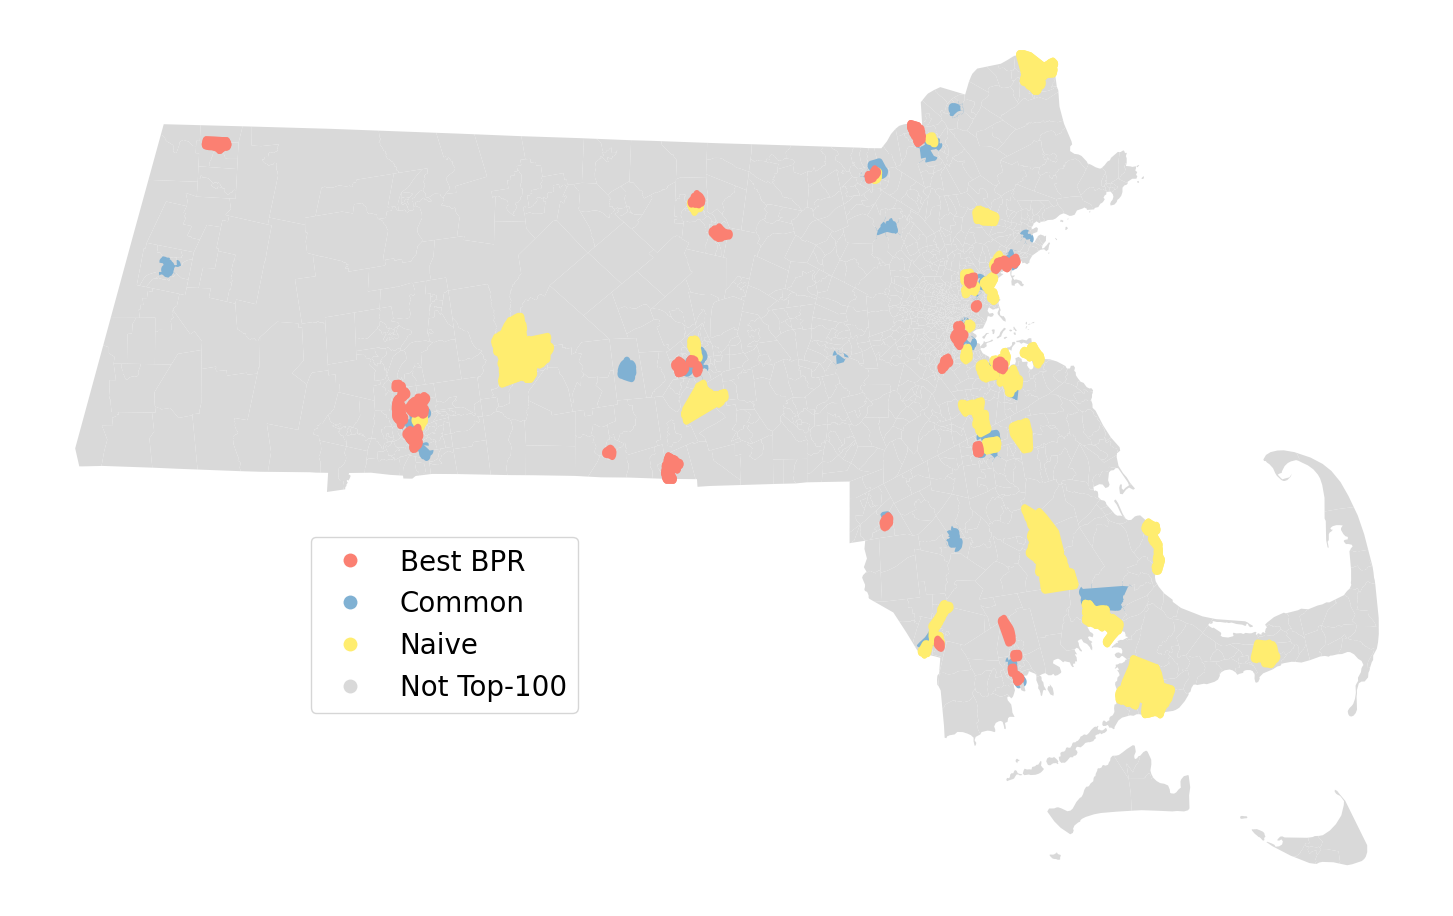

In [79]:

zoom=11
dpi=100
f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
#plt.title('Difference In Tracts',fontsize=36)
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="3%", pad=0.2)
merged_gdf = mass_gdf.merge(gdf_2020.drop(columns='timestep').reset_index()[['geoid','common']], right_on='geoid', left_on='GEOID')
top_100 = merged_gdf['common'] !='Not Top-100'
merged_gdf.loc[top_100, 'geometry'] = merged_gdf.geometry.buffer(0.01)
merged_gdf.plot('common', categorical=True,cmap=final_cmap,ax=ax,legend=True, legend_kwds={'fontsize':20, 
                                                                                           'loc':'lower left',
                                                                                          'bbox_to_anchor':(0.2, 0.2)})
merged_gdf.loc[merged_gdf['common'] =='Naive', :].plot('common', categorical=True,cmap=yellow_cm,ax=ax)
merged_gdf.loc[merged_gdf['common'] =='Best BPR', :].plot('common', categorical=True,cmap=red_cm,ax=ax)
plt.savefig('Tract_Diff.pdf',bbox_inches='tight')

/tmp/ipykernel_148298/1029574140.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['geometry'] = merged_gdf.geometry.buffer(0.00000001)


<Axes: title={'center': 'Difference In Tracts'}>

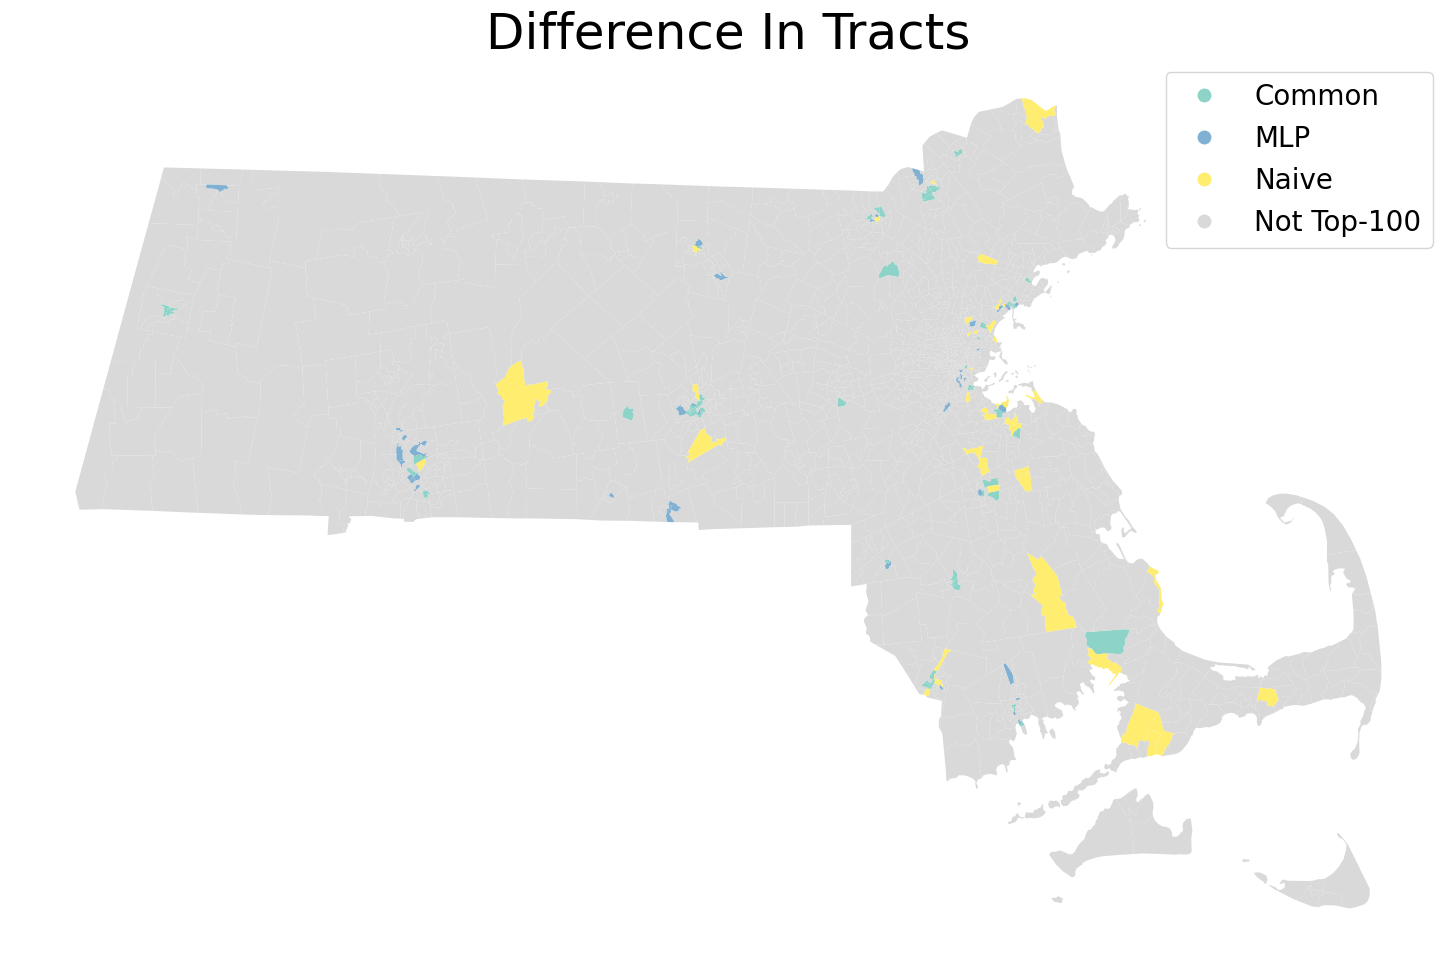

In [42]:

zoom=11
dpi=100
f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
plt.title('Difference In Tracts',fontsize=36)
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="3%", pad=0.2)

merged_gdf = mass_gdf.merge(gdf_2020.drop(columns='timestep').reset_index()[['geoid','common']], right_on='geoid', left_on='GEOID')
merged_gdf['geometry'] = merged_gdf.geometry.buffer(0.00000001)
merged_gdf.plot('common', categorical=True,cmap=new_cmap,ax=ax,legend=True, legend_kwds={'fontsize':20})
#plt.savefig('Tract_Diff.png',bbox_inches='tight')

In [132]:
dir(thing)

['ArtistList',
 '_AxesBase__clear',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autotitlepos',
 '_axes',
 '_axes_locator',
 '_axis_map',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_errorevery_to_mask',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_fully_clipped_to_axes',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spine

In [126]:
matplotlib.colormaps.get_cmap()

TypeError: get_cmap() missing 1 required positional argument: 'cmap'

In [207]:
import matplotlib
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [202]:
third_temp = copy.deepcopy(cmap.colors[2])
cmap.colors[2] = cmap.colors[3]
cmap.colors[3] = third_temp

In [206]:
new_colors = cmap.copy()
new_colors[2], new_colors[3] = new_colors[3], new_colors[2]

TypeError: 'ListedColormap' object is not subscriptable

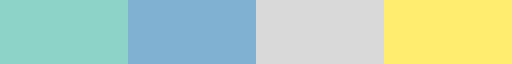

In [246]:
cmap

In [247]:
new_colors

[array([0.55294118, 0.82745098, 0.78039216, 1.        ]),
 array([0.50196078, 0.69411765, 0.82745098, 1.        ]),
 array([1.        , 0.92941176, 0.43529412, 1.        ]),
 array([0.85098039, 0.85098039, 0.85098039, 1.        ])]

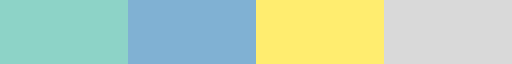

In [55]:
new_cmap

In [242]:
cmap.colors

array([[0.55294118, 0.82745098, 0.78039216, 1.        ],
       [0.50196078, 0.69411765, 0.82745098, 1.        ],
       [1.        , 0.92941176, 0.43529412, 1.        ],
       [0.85098039, 0.85098039, 0.85098039, 1.        ]])

In [31]:
model(train_x_BSF_flat[:,:20,:])

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[ -2.0111182 ,  -9.3552885 ,  -4.6964097 ,  -8.259743  ,
         -7.457417  ,  -7.415754  ,  -9.414444  ,  -7.2734184 ,
         -8.743995  ,  -8.250291  ,  -3.7680516 ,  -1.1653256 ,
         -6.85955   ,  -6.647272  ,  -6.0288367 ,  -6.791356  ,
         -1.490936  ,  -0.6304791 ,  -1.4560447 ,  -7.7240176 ],
       [ -7.3617845 , -13.416383  ,  -9.755944  , -12.891879  ,
        -11.931608  , -12.94731   , -13.3883915 , -12.105556  ,
        -13.177134  , -12.975662  ,  -9.24421   ,  -7.82785   ,
        -11.539018  , -11.38337   , -10.836483  , -11.055315  ,
         -6.60891   ,  -6.2035327 ,  -6.1173043 , -12.17916   ],
       [-12.776976  , -16.101543  , -14.152326  , -17.264118  ,
        -15.838425  , -18.225544  , -17.427671  , -16.324226  ,
        -17.688265  , -17.402214  , -15.216608  ,  -2.7961123 ,
        -15.853359  , -14.778471  , -15.466996  , -14.642088  ,
         -7.6306777 , -11.683145  , -11.790988  , -16

<tf.Tensor: shape=(5, 1620, 45), dtype=float32, numpy=
array([[[-0.5562722 , -0.7476943 ,  1.8676621 , ..., -0.709717  ,
          0.7623672 , -0.16238035],
        [ 0.92590046, -1.2346793 ,  2.1683216 , ..., -1.70167   ,
         -1.0004358 , -1.5601643 ],
        [-0.5562722 , -0.9119409 ,  2.0890598 , ..., -1.5847614 ,
          0.48103076, -0.29624864],
        ...,
        [-0.5562722 , -0.10928559, -0.57171685, ..., -1.0356444 ,
          0.6484082 ,  0.19329613],
        [-0.5562722 ,  0.77835006, -0.37337622, ..., -0.15351482,
         -0.7190996 , -0.95882523],
        [-0.5562722 ,  0.9259689 , -0.39462346, ..., -0.15351482,
         -0.7190996 , -0.95882523]],

       [[-0.5562722 , -0.7476943 ,  1.8676621 , ..., -0.5130977 ,
          0.37276983,  0.3011741 ],
        [-0.5562722 , -1.2346793 ,  2.1683216 , ..., -1.6690774 ,
         -0.3619094 , -0.06126708],
        [-0.5562722 , -0.9119409 ,  2.0890598 , ..., -0.9913609 ,
         -0.5307111 , -0.1246409 ],
        ...,

In [32]:
merged_gdf.buffer(0.1)

/tmp/ipykernel_148298/3412278043.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf.buffer(0.1)


0       POLYGON ((-70.47044 41.62087, -70.47305 41.630...
1       POLYGON ((-70.58634 41.70340, -70.58833 41.708...
2       POLYGON ((-71.22956 42.63971, -71.23524 42.643...
3       POLYGON ((-71.05097 42.48545, -71.05120 42.490...
4       POLYGON ((-71.03867 42.46869, -71.03904 42.478...
                              ...                        
1609    POLYGON ((-71.80464 42.12420, -71.80466 42.124...
1610    POLYGON ((-71.17533 41.67113, -71.17644 41.680...
1611    POLYGON ((-71.30196 41.64689, -71.32043 41.667...
1612    POLYGON ((-70.89786 42.16803, -70.90410 42.175...
1613    POLYGON ((-70.83443 42.10116, -70.83662 42.102...
Length: 1614, dtype: geometry

/tmp/ipykernel_148298/699757329.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf.buffer(0.01).plot(cmap)


<Axes: >

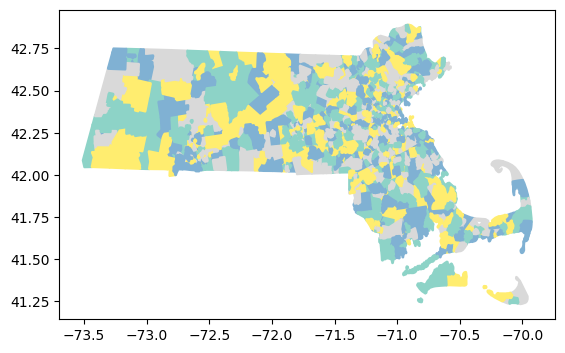

In [37]:
merged_gdf.buffer(0.01).plot(cmap)